In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader
import json
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
# ------------------------------------------------------------
# Device configuration
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# ------------------------------------------------------------
# Data transforms
# Train transform includes augmentation
# Validation transform does NOT include augmentation
# ------------------------------------------------------------
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.7,1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.RandomHorizontalFlip(),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [4]:
# ------------------------------------------------------------
# Load Ground Truth
# ------------------------------------------------------------
with open("Data/Jersey/train_gt.json") as f:
    gt = json.load(f)

# Remove -1 labels
gt = {k:int(v) for k,v in gt.items() if int(v) != -1}

# ------------------------------------------------------------
# Create proper jersey number mapping
# ------------------------------------------------------------
unique_numbers = sorted(set(gt.values()))   # REAL jersey numbers

label_map = {num:i for i,num in enumerate(unique_numbers)}
reverse_label_map = {i:num for num,i in label_map.items()}

num_classes = len(unique_numbers)

print("Total jersey number classes:", num_classes)

Total jersey number classes: 44


In [5]:
class JerseyDataset(Dataset):
    def __init__(self, image_root, gt_dict, transform=None):
        self.image_root = image_root
        self.gt_dict = gt_dict
        self.keys = list(gt_dict.keys())
        self.transform = transform
        
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, idx):
        key = self.keys[idx]

        # Convert jersey number to class index
        jersey_number = self.gt_dict[key]
        label = label_map[jersey_number]

        folder_path = os.path.join(self.image_root, key)
        image_files = os.listdir(folder_path)
        image_path = os.path.join(folder_path, image_files[0])
        
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# ------------------------------------------------------------
# Load dataset using ImageFolder
# Folder names are automatically treated as class labels
# ------------------------------------------------------------
dataset = JerseyDataset("Data/Jersey/images", gt, transform=train_transform)

# Get all indices and labels
indices = list(range(len(dataset)))
labels = [dataset[i][1] for i in indices]

In [7]:
from collections import Counter

label_counts = Counter(labels)

sorted_label_counts = dict(sorted(label_counts.items(), key=lambda item: item[1]))

print("Class distribution (class index: count):")
for label, count in sorted_label_counts.items():
    print(f"Class {label} (Jersey {reverse_label_map[label]}): {count} samples")

Class distribution (class index: count):
Class 42 (Jersey 75): 1 samples
Class 35 (Jersey 38): 1 samples
Class 43 (Jersey 93): 1 samples
Class 40 (Jersey 56): 1 samples
Class 11 (Jersey 13): 2 samples
Class 33 (Jersey 35): 2 samples
Class 30 (Jersey 32): 2 samples
Class 16 (Jersey 18): 3 samples
Class 17 (Jersey 19): 4 samples
Class 19 (Jersey 21): 5 samples
Class 36 (Jersey 40): 6 samples
Class 41 (Jersey 62): 12 samples
Class 38 (Jersey 50): 13 samples
Class 15 (Jersey 17): 13 samples
Class 14 (Jersey 16): 13 samples
Class 37 (Jersey 44): 14 samples
Class 13 (Jersey 15): 14 samples
Class 39 (Jersey 55): 14 samples
Class 1 (Jersey 2): 15 samples
Class 29 (Jersey 31): 15 samples
Class 21 (Jersey 23): 15 samples
Class 32 (Jersey 34): 16 samples
Class 20 (Jersey 22): 17 samples
Class 24 (Jersey 26): 18 samples
Class 10 (Jersey 11): 19 samples
Class 6 (Jersey 7): 19 samples
Class 27 (Jersey 29): 20 samples
Class 26 (Jersey 28): 21 samples
Class 28 (Jersey 30): 24 samples
Class 18 (Jersey 

In [8]:
# Keep only classes with >=2 samples
valid_indices = [
    idx for idx in indices
    if label_counts[dataset[idx][1]] >= 2
]

valid_labels = [dataset[i][1] for i in valid_indices]

train_idx, val_idx = train_test_split(
    valid_indices,
    test_size=0.2,
    stratify=valid_labels,
    random_state=42
)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

# Apply validation transform separately
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [9]:
# ------------------------------------------------------------
# Model definition
# ------------------------------------------------------------
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [10]:
# ------------------------------------------------------------
# Loss function and optimizer
# Only train final layer parameters
# ------------------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [11]:
# ------------------------------------------------------------
# Checkpoint handling
# ------------------------------------------------------------
checkpoint_path = "jersey_classifier_checkpoint.pth"
start_epoch = 0
best_accuracy = 0

if os.path.exists(checkpoint_path):
    print("Loading existing checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    start_epoch = checkpoint["epoch"] + 1
    best_accuracy = checkpoint["best_accuracy"]

    print(f"Resuming from epoch {start_epoch}")

Loading existing checkpoint...
Resuming from epoch 49


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Training Loop
num_epochs = 50
CHECKPOINT_PATH = "jersey_checkpoint.pth"

try:
    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # ---------------- Validation ----------------
        model.eval()
        all_preds = []
        all_labels = []
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Evaluation metrics
        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print("Train Loss:", running_loss / len(train_loader))
        print("Val Loss:", val_loss / len(val_loader))
        print("Accuracy:", acc)
        print("Precision:", prec)
        print("Recall:", rec)
        print("F1 Score:", f1)

        # Save best model separately
        if acc > best_accuracy:
            best_accuracy = acc
            torch.save(model.state_dict(), "best_jersey_model.pth")
            print("Best model updated.")

        # Save checkpoint after every epoch
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_accuracy": best_accuracy
        }, checkpoint_path)

except KeyboardInterrupt:
    print("\nTraining interrupted. Saving checkpoint...")

    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "best_accuracy": best_accuracy
    }, checkpoint_path)

    print("Checkpoint saved successfully.")

# ----------------------------
# Save Final Model Separately
# ----------------------------
torch.save(model.state_dict(), "jersey_classifier_final.pth")
print("Training complete. Final model saved.")



Epoch [50/50]
Train Loss: 1.112227948812338
Val Loss: 0.9824265156473432
Accuracy: 0.7794117647058824
Precision: 0.8500438553070132
Recall: 0.8368175897587663
F1 Score: 0.8262490946973706
Best model updated.
Training complete. Final model saved.


In [13]:
print("Unique labels in validation set:", sorted(set(all_labels)))
print("Total unique labels in val:", len(set(all_labels)))

Unique labels in validation set: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(31), np.int64(32), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(41)]
Total unique labels in val: 37


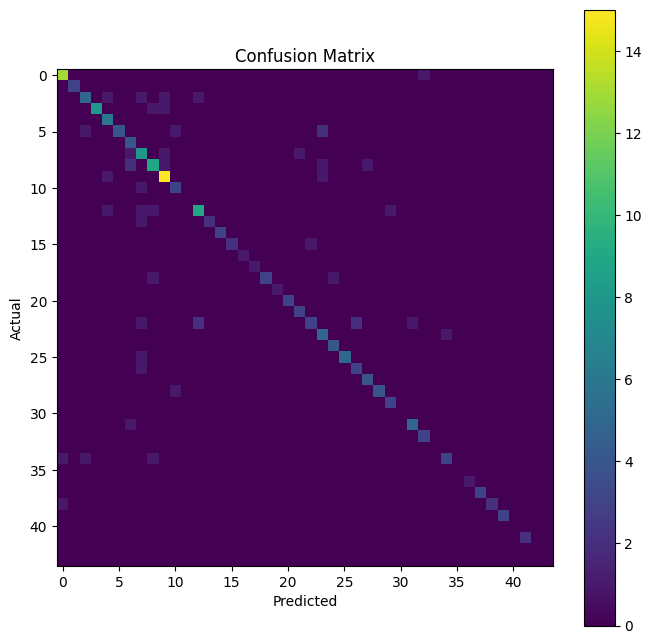

In [14]:
# ------------------------------------------------------------
# Confusion Matrix
# ------------------------------------------------------------
cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

In [15]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import json

# ------------------------------------------------------------
# Device
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------------------------------------
# Recreate label mapping EXACTLY like training
# ------------------------------------------------------------
with open("Data/Jersey/train_gt.json") as f:
    gt = json.load(f)

gt = {k:int(v) for k,v in gt.items() if int(v) != -1}

unique_numbers = sorted(set(gt.values()))
label_map = {num:i for i,num in enumerate(unique_numbers)}

# Reverse mapping (index -> jersey number)
reverse_label_map = {v:k for k,v in label_map.items()}

num_classes = len(unique_numbers)

print("Total classes:", num_classes)

# ------------------------------------------------------------
# Recreate Model Architecture EXACTLY like training
# ------------------------------------------------------------
model = models.resnet18(weights=None)

# Freeze backbone (not mandatory for inference but safe)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

# ------------------------------------------------------------
# Load Saved Best Weights
# ------------------------------------------------------------
model.load_state_dict(torch.load("best_jersey_model.pth", map_location=device))

model.eval()

print("Best model loaded successfully.")

Using device: cpu
Total classes: 44
Best model loaded successfully.


In [16]:
# ------------------------------------------------------------
# Single Image Prediction Function
# Returns Jersey Number
# ------------------------------------------------------------
def predict_image(image_path):

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    predicted_index = predicted.item()

    # Convert class index back to REAL jersey number
    jersey_number = reverse_label_map[predicted_index]

    return jersey_number


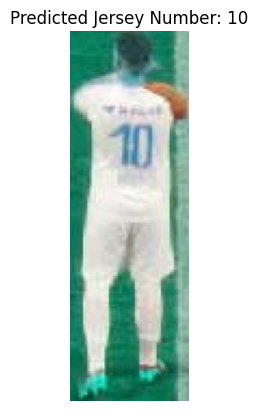

In [17]:
# ------------------------------------------------------------
# Example prediction
# ------------------------------------------------------------
test_image = "Data/Jersey/images/0/0_1.jpg"

prediction = predict_image(test_image)

plt.figure()
image = cv2.imread(test_image)
plt.imshow(image)
plt.title(f"Predicted Jersey Number: {prediction}")
plt.axis("off")
plt.show()

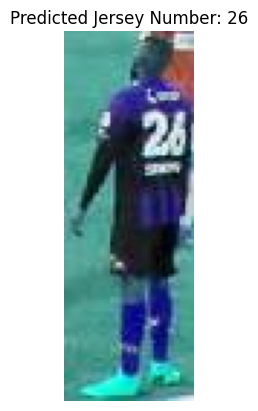

In [18]:
# ------------------------------------------------------------
# Example prediction
# ------------------------------------------------------------
test_image = "Data/Jersey/images/1412/1412_498.jpg"

prediction = predict_image(test_image)

plt.figure()
image = cv2.imread(test_image)
plt.imshow(image)
plt.title(f"Predicted Jersey Number: {prediction}")
plt.axis("off")
plt.show()